In [2]:
### Install the required libraries

# Install the required libraries

In [ ]:
!pip install pystac_client
!pip install odc-stac
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pystac_client
import odc.stac
import rioxarray as rxr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
STAC_URL = "https://earth-search.aws.element84.com/v1"
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

catalog = pystac_client.Client.open(STAC_URL)

print(f'Connected to {catalog.description}')

Connected to A STAC API of public datasets on AWS


In [ ]:
#Area of interest

bbox=[75.596924,12.793053,75.819397,12.908198]

In [ ]:
cloud_free_search = catalog.search(
    collections = 'sentinel-2-l2a',
    bbox = bbox,
    datetime = '2024-01-01/2024-12-31',
    query = {'eo:cloud_cover': {'lt': 1}})



In [ ]:
for i in cloud_free_search.items():
  print(i)

<Item id=S2B_43PEQ_20241231_0_L2A>
<Item id=S2B_43PEQ_20240326_0_L2A>
<Item id=S2A_43PEQ_20240220_0_L2A>
<Item id=S2A_43PEQ_20240210_0_L2A>
<Item id=S2B_43PEQ_20240205_0_L2A>
<Item id=S2A_43PEQ_20240131_0_L2A>


In [ ]:
cloud_free_items = list(cloud_free_search.items())

In [ ]:
len(cloud_free_items)

6

# Cloud free data visualization

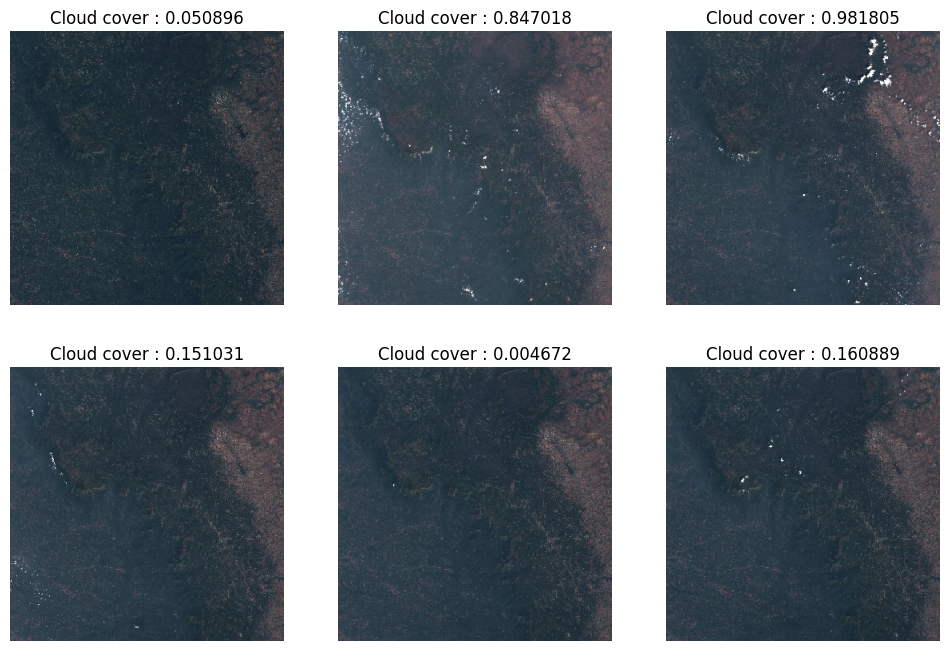

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import io
import requests

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

axes = ax.flatten()

for i in range(0, len(cloud_free_items)):

  item = cloud_free_items[i].assets

  img_data = requests.get(item["thumbnail"].href).content
  axes[i].imshow(Image.open(io.BytesIO(img_data)))
  axes[i].axis('off')
  cloud_cover = cloud_free_items[i].properties['eo:cloud_cover']
  axes[i].set_title(f'Cloud cover : {cloud_cover}')

In [ ]:
cloud_free_ds = odc.stac.load(
    [cloud_free_items[0]],
    bands=['red', 'green', 'blue'],
    crs='EPSG:32643',
    resolution=10,
    chunks={'x': 1000, 'y': 1000}
)

In [ ]:
cloud_free_array = np.array(cloud_free_ds.to_dataarray())

# Cloudy data search

In [ ]:
cloudy_search = catalog.search(
    collections = ['sentinel-2-l2a'],
    bbox = bbox,
    datetime = '2024-01-01/2024-12-01',
    query = {'eo:cloud_cover':{'lt': 40}}
)

In [ ]:
cloudy_items = list(cloudy_search.items())

In [ ]:
len(cloudy_items)

30

In [ ]:
filtered = []

for i in cloudy_items:
    if 30 < i.properties['eo:cloud_cover'] < 40:
        filtered.append(i)


In [ ]:
len(filtered)

6

# Cloudy data visualization

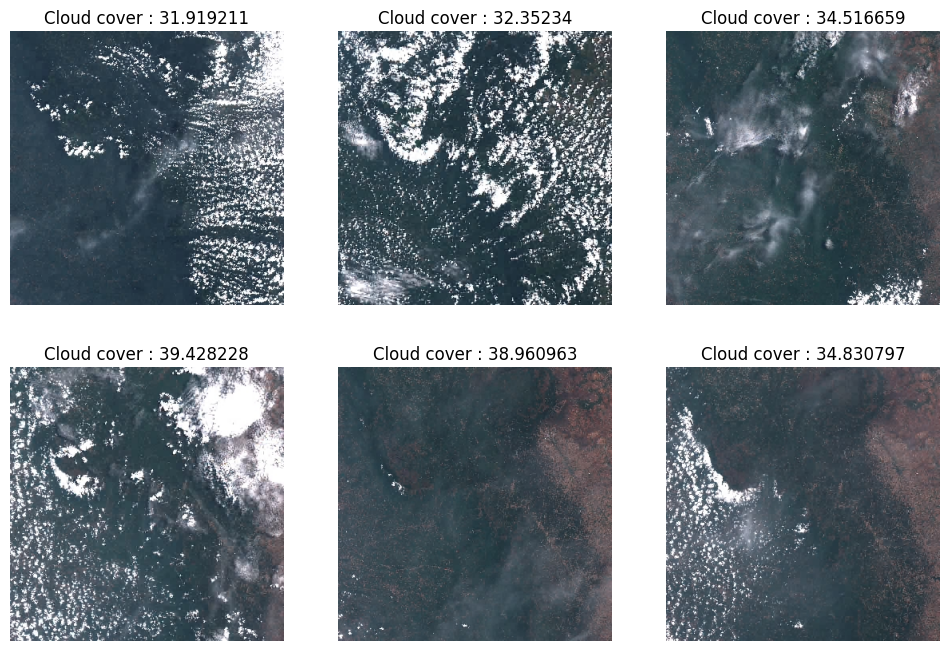

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))

axes = ax.flatten()

for i in range(0, len(filtered)):

  item = filtered[i].assets

  img_data = requests.get(item["thumbnail"].href).content
  axes[i].imshow(Image.open(io.BytesIO(img_data)))
  axes[i].axis('off')
  cloud_cover = filtered[i].properties['eo:cloud_cover']
  axes[i].set_title(f'Cloud cover : {cloud_cover}')



In [ ]:
cloudy__ds = odc.stac.load(
    [filtered[2]],
    bands=['red', 'green', 'blue'],
    crs='EPSG:32643',
    resolution=10,
    chunks={'x': 1000, 'y': 1000}
)

In [ ]:
cloudy__ds

<xarray.Dataset> Size: 724MB
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 88kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 8B 2024-05-15T05:35:20.060000
Data variables:
    red          (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [ ]:
rgb_cloudy = cloudy__ds.to_dataarray().squeeze().transpose('y','x', 'variable')

In [ ]:
cloud_free_ds

<xarray.Dataset> Size: 724MB
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 88kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 8B 2024-12-31T05:35:22.478000
Data variables:
    red          (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 241MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [ ]:
rgb_cloud_free = cloud_free_ds.to_dataarray().squeeze().transpose('y','x', 'variable')

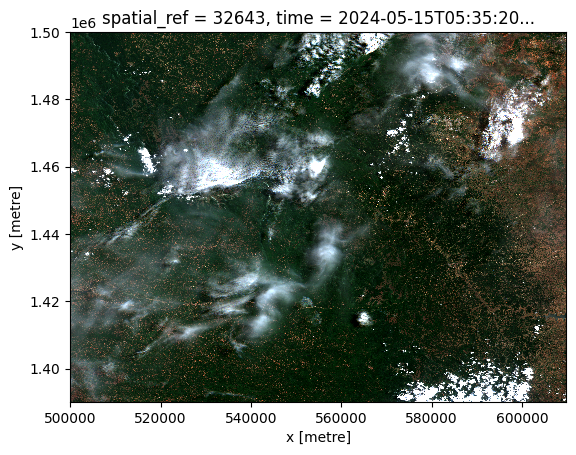

In [ ]:
rgb_cloudy.plot.imshow(robust = True)

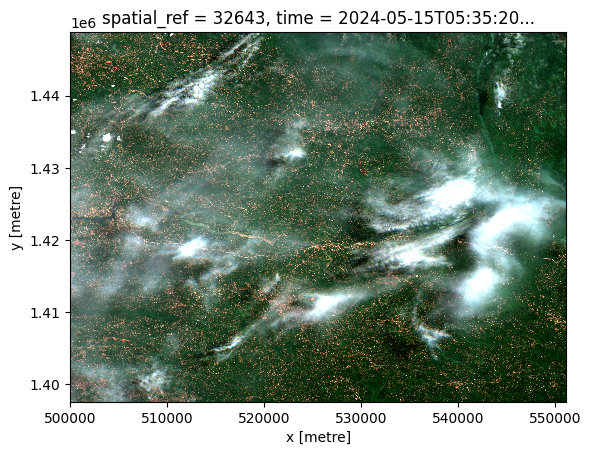

In [ ]:
#Focus only on the cloudy part of the tile

rgb_cloudy[5120:10240, :5120, :].plot.imshow(robust = True)

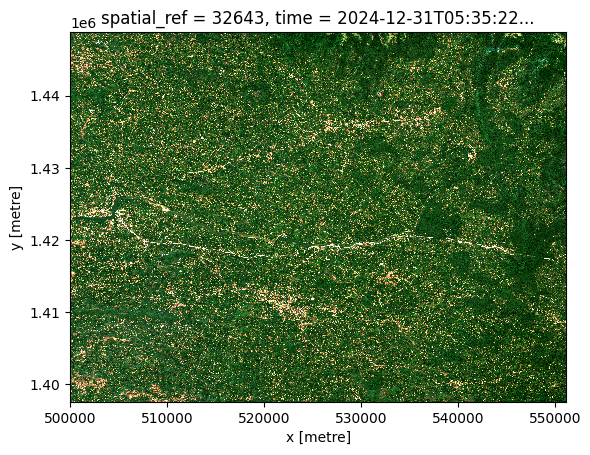

In [ ]:
rgb_cloud_free[5120:10240, :5120, :].plot.imshow(robust = True)

In [ ]:
rgb_cloudy_subset = rgb_cloudy[5120:10240, :5120, :]

In [ ]:
rgb_cloudfree_subset = rgb_cloud_free[5120:10240, :5120, :]

In [ ]:
rgb_cloudy_subset

<xarray.DataArray (y: 5120, x: 5120, variable: 3)> Size: 157MB
dask.array<getitem, shape=(5120, 5120, 3), dtype=uint16, chunksize=(1000, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 41kB 1.449e+06 1.449e+06 ... 1.398e+06 1.398e+06
  * x            (x) float64 41kB 5e+05 5e+05 5e+05 ... 5.512e+05 5.512e+05
    spatial_ref  int32 4B 32643
    time         datetime64[ns] 8B 2024-05-15T05:35:20.060000
  * variable     (variable) object 24B 'red' 'green' 'blue'

In [ ]:
rgb_cloudy_subset

<xarray.DataArray (y: 5120, x: 5120, variable: 3)> Size: 157MB
dask.array<getitem, shape=(5120, 5120, 3), dtype=uint16, chunksize=(1000, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 41kB 1.449e+06 1.449e+06 ... 1.398e+06 1.398e+06
  * x            (x) float64 41kB 5e+05 5e+05 5e+05 ... 5.512e+05 5.512e+05
    spatial_ref  int32 4B 32643
    time         datetime64[ns] 8B 2024-05-15T05:35:20.060000
  * variable     (variable) object 24B 'red' 'green' 'blue'

In [ ]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import patchify

In [ ]:
normalized_cloud_free = 2 * (np.array(rgb_cloudfree_subset) - np.array(rgb_cloudfree_subset).min()) / (np.array(rgb_cloudfree_subset).max() - np.array(rgb_cloudfree_subset).min()) - 1

In [ ]:
normalized_cloudy = 2 * (np.array(rgb_cloudy_subset) - np.array(rgb_cloudy_subset).min()) / (np.array(rgb_cloudy_subset).max() - np.array(rgb_cloudy_subset).min()) - 1

In [ ]:
normalized_cloud_free.min(), normalized_cloud_free.max()

(np.float64(-1.0), np.float64(1.0))

In [ ]:
normalized_cloudy.min(), normalized_cloudy.max()

(np.float64(-1.0), np.float64(1.0))

In [ ]:
cloud_free_patches = patchify.patchify(normalized_cloud_free, (128, 128, 3), step = 128)
cloud_free_patches = cloud_free_patches.reshape(1600, 128, 128, 3)

In [ ]:
cloudy_patches = patchify.patchify(normalized_cloudy, (128, 128, 3), step = 128)
cloudy_patches = cloudy_patches.reshape(1600, 128, 128, 3)

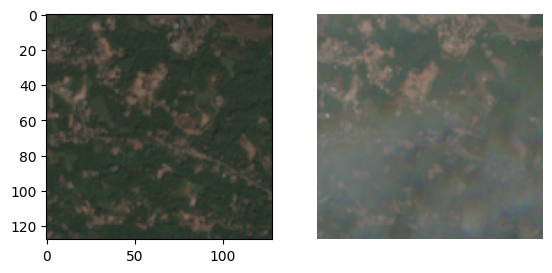

In [ ]:
import random

idx = random.randint(0, len(cloudy_patches))

fig, ax = plt.subplots(1, 2)

axes = ax.flatten()

x = ((cloud_free_patches[idx] + 1) / 2)**0.4
y = ((cloudy_patches[idx] + 1) / 2)**0.4

axes[0].imshow(x)
axes[1].imshow(y)
plt.axis('off')
plt.show()

In [ ]:
cloud_free_patches[0].shape

(128, 128, 3)

# Model building

In [3]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
def define_discriminator(image_shape):

	init = RandomNormal(stddev=0.02)


	in_src_image = Input(shape=image_shape)

	in_target_image = Input(shape=image_shape)

	merged = Concatenate()([in_src_image, in_target_image])

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	model = Model([in_src_image, in_target_image], patch_out)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):

	init = RandomNormal(stddev=0.02)

	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	if batchnorm:
		g = BatchNormalization()(g, training=True)

	g = LeakyReLU(alpha=0.2)(g)
	return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):

	init = RandomNormal(stddev=0.02)

	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	g = BatchNormalization()(g, training=True)

	if dropout:
		g = Dropout(0.5)(g, training=True)

	g = Concatenate()([g, skip_in])

	g = Activation('relu')(g)
	return g


In [ ]:
def define_generator(image_shape=(128,128,3)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)


    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
    b = Activation('relu')(b)

    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)

    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model


In [ ]:
def define_gan(g_model, d_model, image_shape):

	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False

	in_src = Input(shape=image_shape)

	gen_out = g_model(in_src)

	dis_out = d_model([in_src, gen_out])

	model = Model(in_src, [dis_out, gen_out])

	opt = Adam(learning_rate=0.0002, beta_1=0.5)

	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
dataset = [cloudy_patches, cloud_free_patches]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):

	trainA, trainB = dataset

	ix = randint(0, trainA.shape[0], n_samples)

	X1, X2 = trainA[ix], trainB[ix]

	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):

	X = g_model.predict(samples)

	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1):

    n_patch = d_model.output_shape[1]

    trainA, trainB = dataset

    bat_per_epo = int(len(trainA) / n_batch)

    n_steps = bat_per_epo * n_epochs

    for i in range(n_steps):

        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        g_loss, *_ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, d_loss1, d_loss2, g_loss))


    d_model.save('discriminator_epoch_1.h5')
    gan_model.save('gan_model_epoch_1.h5')
    g_model.save('g_model_epoch1.h5')
    print('Model saved after one epoch.')


In [ ]:
image_shape = cloudy_patches.shape[1:]

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
cloudy_patches.shape[1:]

(128, 128, 3)

In [ ]:
from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1)


stop1 = datetime.now()
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
>1, d1[0.488] d2[0.489] g[2.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
>2, d1[0.488] d2[0.489] g[2.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
>3, d1[0.488] d2[0.489] g[2.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
>4, d1[0.488] d2[0.489] g[2.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
>5, d1[0.488] d2[0.489] g[2.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
>6, d1[0.488] d2[0.489] g[2.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
>7, d1[0.488] d2[0.489] g[2.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
>8, d1[0.488] d2[0.489] g[2.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
>9, d1[0.488] d2[0.489] g[2.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
>10, d1[0.488] d2[0.489] g[2.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
>11, d1[0.488] d2[0.489] g[2.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
>12, d1[0.488] d2[0.489] g[2.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
>13, d1[0.489] d2[0.489] g[2.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
>14, d1[0.489] d2[0.4

>1600, d1[0.484] d2[0.484] g[1.812]
Model saved after one epoch.
Execution time is:  0:34:03.614167


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('drive/MyDrive')
# os.listdir()

In [ ]:
from tensorflow.keras.models import load_model

g_model = load_model('g_model_epoch1.h5')


# Visualize the model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


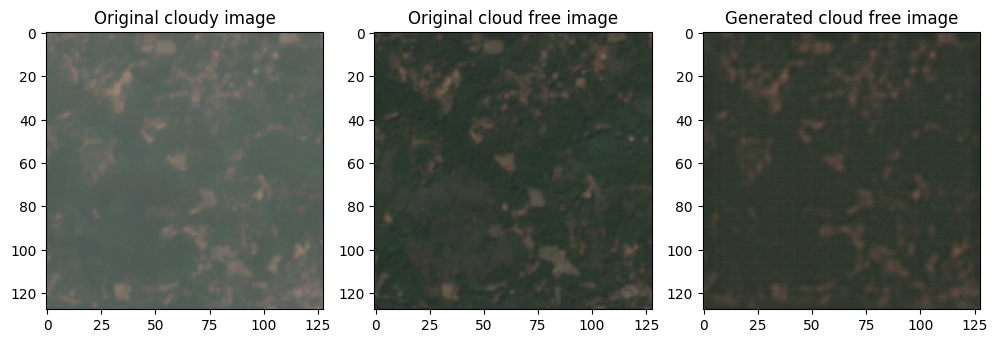

In [ ]:
[X_realA, X_realB], _ = generate_real_samples(dataset, 1, 1)

X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

X_realA = ((X_realA + 1) / 2)**0.4
X_realB = ((X_realB + 1) / 2)**0.4
X_fakeB = ((X_fakeB + 1) / 2)** 0.4

fig, ax = plt.subplots(1, 3, figsize = (10, 6))
axes = ax.flatten()

axes[0].imshow(np.squeeze(X_realA))
axes[0].set_title('Original cloudy image')

axes[1].imshow(np.squeeze(X_realB))
axes[1].set_title('Original cloud free image')

axes[2].imshow(np.squeeze(X_fakeB))
axes[2].set_title('Generated cloud free image')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


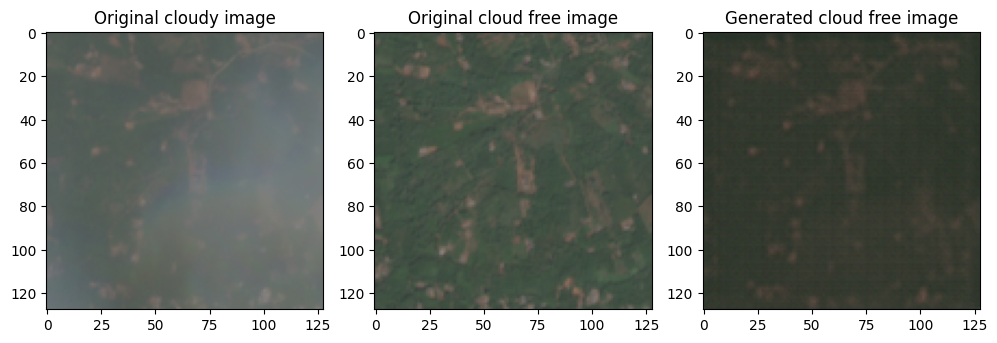

In [ ]:
[X_realA, X_realB], _ = generate_real_samples(dataset, 1, 1)

X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

X_realA = ((X_realA + 1) / 2)**0.4
X_realB = ((X_realB + 1) / 2)**0.3
X_fakeB = ((X_fakeB + 1) / 2)** 0.4


fig, ax = plt.subplots(1, 3, figsize = (10, 6))
axes = ax.flatten()

axes[0].imshow(np.squeeze(X_realA))
axes[0].set_title('Original cloudy image')

axes[1].imshow(np.squeeze(X_realB))
axes[1].set_title('Original cloud free image')

axes[2].imshow(np.squeeze(X_fakeB))
axes[2].set_title('Generated cloud free image')

plt.tight_layout()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


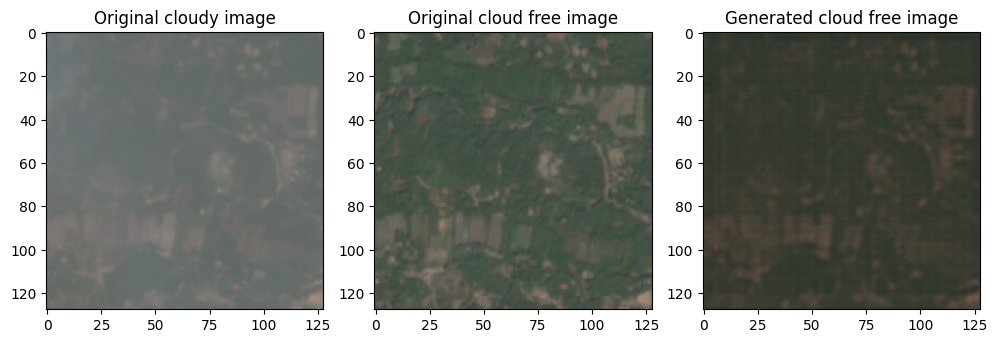

In [ ]:
[X_realA, X_realB], _ = generate_real_samples(dataset, 1, 1)

X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

X_realA = ((X_realA + 1) / 2)**0.4
X_realB = ((X_realB + 1) / 2)**0.3
X_fakeB = ((X_fakeB + 1) / 2)** 0.4

fig, ax = plt.subplots(1, 3, figsize = (10, 6))
axes = ax.flatten()

axes[0].imshow(np.squeeze(X_realA))
axes[0].set_title('Original cloudy image')

axes[1].imshow(np.squeeze(X_realB))
axes[1].set_title('Original cloud free image')

axes[2].imshow(np.squeeze(X_fakeB))
axes[2].set_title('Generated cloud free image')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


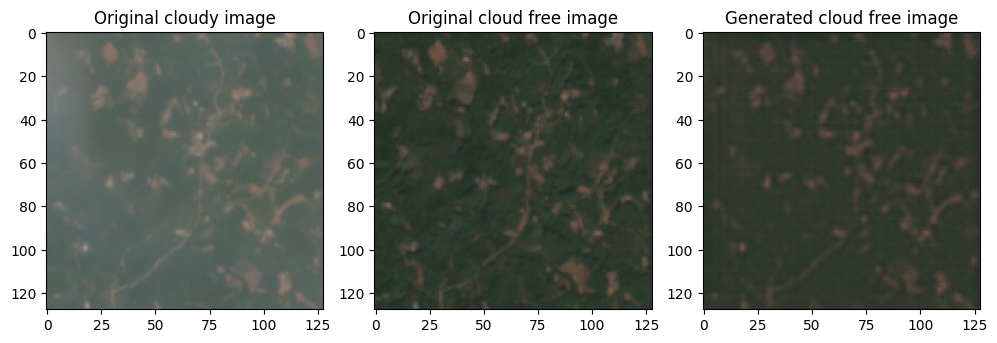

In [ ]:
[X_realA, X_realB], _ = generate_real_samples(dataset, 1, 1)

X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

X_realA = ((X_realA + 1) / 2)**0.4
X_realB = ((X_realB + 1) / 2)**0.4
X_fakeB = ((X_fakeB + 1) / 2)** 0.4

fig, ax = plt.subplots(1, 3, figsize = (10, 6))
axes = ax.flatten()

axes[0].imshow(np.squeeze(X_realA))
axes[0].set_title('Original cloudy image')

axes[1].imshow(np.squeeze(X_realB))
axes[1].set_title('Original cloud free image')

axes[2].imshow(np.squeeze(X_fakeB))
axes[2].set_title('Generated cloud free image')

plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


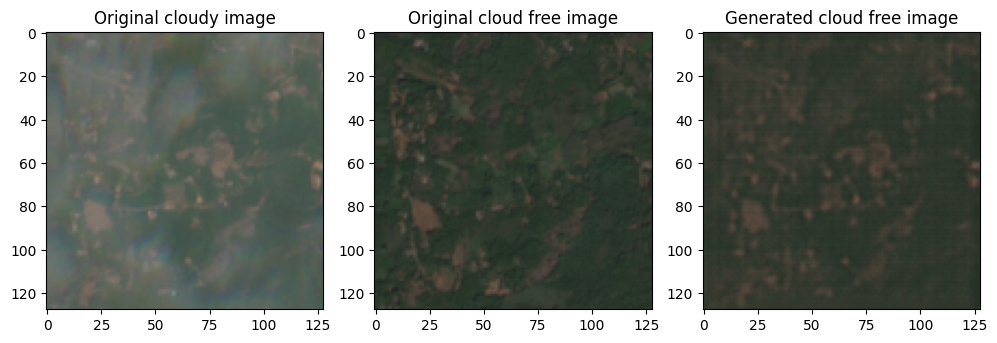

In [ ]:
[X_realA, X_realB], _ = generate_real_samples(dataset, 1, 1)

X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

X_realA = ((X_realA + 1) / 2)**0.4
X_realB = ((X_realB + 1) / 2)**0.4
X_fakeB = ((X_fakeB + 1) / 2)** 0.4

fig, ax = plt.subplots(1, 3, figsize = (10, 6))
axes = ax.flatten()

axes[0].imshow(np.squeeze(X_realA))
axes[0].set_title('Original cloudy image')

axes[1].imshow(np.squeeze(X_realB))
axes[1].set_title('Original cloud free image')

axes[2].imshow(np.squeeze(X_fakeB))
axes[2].set_title('Generated cloud free image')

plt.tight_layout()

# Deploy the model to hugging face

In [ ]:
!pip install huggingface_hub

In [ ]:
import huggingface_hub as hf

In [ ]:
hf.login()

In [ ]:
hf.create_repo("cloud-removal-model", repo_type="model")

In [ ]:
hf.upload_file(
    path_or_fileobj="/content/drive/MyDrive/g_model_epoch1.h5",
    path_in_repo="g_model_epoch1.h5",
    repo_id="SanjayGeospatial/cloud-removal-model",  # Replace with your actual username and repo
    repo_type="model"
)

g_model_epoch1.h5:   0%|          | 0.00/168M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SanjayGeospatial/cloud-removal-model/commit/fd495092fa7c0478e289620e34d52735827cf8ff', commit_message='Upload g_model_epoch1.h5 with huggingface_hub', commit_description='', oid='fd495092fa7c0478e289620e34d52735827cf8ff', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SanjayGeospatial/cloud-removal-model', endpoint='https://huggingface.co', repo_type='model', repo_id='SanjayGeospatial/cloud-removal-model'), pr_revision=None, pr_num=None)